In [11]:
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import mean_squared_error,mean_absolute_error,roc_auc_score
from math import sqrt
from surprise import Dataset, Reader
from surprise import BaselineOnly
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split,GridSearchCV
from surprise.prediction_algorithms import Prediction


In [2]:
final_dataset=pd.read_csv("nan_clean_dataset.csv")
final_dataset['date'] =pd.to_datetime(final_dataset.date)
final_dataset.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'user_id', 'business_id', 'review_id',
       'rating', 'date', 'useful_x', 'funny_x', 'cool_x', 'text', 'name_x',
       'address', 'city', 'state', 'postal_code', 'latitude', 'longitude',
       'stars', 'review_count_x', 'category', 'RestaurantsTakeOut',
       'RestaurantsPriceRange2', 'GoodForKids', 'HasTV',
       'RestaurantsGoodForGroups', 'RestaurantsReservations', 'WiFi',
       'RestaurantsAttire', 'Alcohol', 'OutdoorSeating', 'RestaurantsDelivery',
       'BikeParking', 'average_stars', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool_y',
       'elite', 'fans', 'friends', 'funny_y', 'name_y', 'review_count_y',
       'useful_y', 'yelping_since'],
      dtype='object')

In [3]:
final_dataset = final_dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1','elite','address','state','postal_code','latitude','longitude'])


# Select active users from the data

In [4]:
users_=final_dataset.user_id.value_counts()
active_users = users_.loc[users_ >5].index.to_list()
active = pd.DataFrame({"user_id": active_users})
df_sample2 = pd.merge(left = final_dataset,right= active,left_on='user_id',right_on='user_id')

# Distribution of Ratings on sampled data

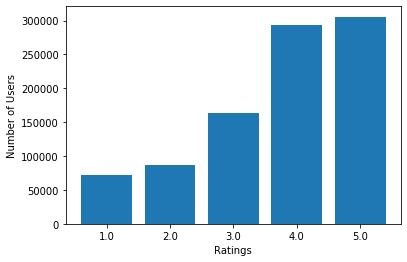

In [7]:
x=df_sample2['rating'].value_counts().rename_axis('ratings').reset_index(name='UserCount').sort_values(by=['ratings'])
plt.bar([i for i in range(5)], x['UserCount'])
plt.xticks([i for i in range(5)],x['ratings'])
plt.xlabel("Ratings")
plt.ylabel("Number of Users")
plt.show()



# Create Train and Test data

In [8]:
df=df_sample2.groupby(['user_id']).date.apply(lambda x: max(x)).reset_index()
df_test = pd.merge(df_sample2,df, how='inner',on=['user_id','date'])
df_train=df_sample2[~df_sample2.isin(df_test.to_dict('l')).all(1)]

In [9]:
df_train.head()

,user_id,business_id,review_id,rating,date,useful_x,funny_x,cool_x,text,name_x,...,compliment_profile,compliment_writer,cool_y,fans,friends,funny_y,name_y,review_count_y,useful_y,yelping_since
0,hG7b0MtEbXx5QzbzE6C_VA,Y07qIurPKiUJDnTZWxZN2A,HeTRGukwBk1TPoX0dr4xZA,5.0,2012-08-28 23:34:11,0.0,0.0,0.0,Not a huge selection but what they do have is ...,Bistro Buffet,...,0,0,0,0,frQs7y5qa-X1pvAM0sJe1w,4,Stefan,10,18,2008-07-10 17:24:47
1,hG7b0MtEbXx5QzbzE6C_VA,eSLwC2iFJOU4UWXyuPiTpg,C_25_cKO3JXflunMIwBHdA,1.0,2008-08-23 20:07:25,0.0,0.0,0.0,"If you are a grown man, you will leave hungry ...",Hennessey's Tavern,...,0,0,0,0,frQs7y5qa-X1pvAM0sJe1w,4,Stefan,10,18,2008-07-10 17:24:47
3,hG7b0MtEbXx5QzbzE6C_VA,0giQuOv-hLFlVuwgw_VG9A,tDpkjj18ZnumFUa91M34eA,2.0,2014-12-11 03:51:29,0.0,2.0,0.0,FE has gone from being a food store to a quasi...,Fresh & Easy,...,0,0,0,0,frQs7y5qa-X1pvAM0sJe1w,4,Stefan,10,18,2008-07-10 17:24:47
4,FIk4lQQu1eTe2EpzQ4xhBA,Y07qIurPKiUJDnTZWxZN2A,1gAM0UO81wbM2vdRrQtywA,2.0,2011-11-06 05:11:33,0.0,0.0,0.0,Small breakfast buffet. I was surprised it wa...,Bistro Buffet,...,3,32,726,63,"WeIrA7LbdfS5HeV13iymuw, QFjqxXn3acDC7hckFGUKMg...",314,Carol,866,1635,2010-08-26 22:09:14
5,FIk4lQQu1eTe2EpzQ4xhBA,9edPSkfXKsJmkZYIaOmA7Q,5m91U7Ha0XrGgP82-lc-Sg,4.0,2012-06-12 02:07:44,2.0,0.0,1.0,"I'm not much for shopping, I do not like to ju...",Las Vegas South Premium Outlets,...,3,32,726,63,"WeIrA7LbdfS5HeV13iymuw, QFjqxXn3acDC7hckFGUKMg...",314,Carol,866,1635,2010-08-26 22:09:14


# Create X_train X_test Y_train Y_test

In [69]:
X_train=df_train.loc[:, df_train.columns != 'rating']
Y_train=df_train[['rating']]
X_test=df_test.loc[:, df_test.columns != 'rating']
Y_test=df_test[['rating']]

In [70]:
X_train.to_csv("X_train.csv")
X_test.to_csv("X_test.csv")
Y_test.to_csv("y_test.csv")
Y_train.to_csv("y_train.csv")

#  Baseline Model
# user and item bias baseline

In [15]:
reader = Reader(rating_scale=(1,5))
train_ = Dataset.load_from_df(df_train[['user_id', 'business_id', 'rating']], reader)
trainset = train_.build_full_trainset()

In [16]:
algo = BaselineOnly()
algo.fit(trainset)

Estimating biases using als...


In [17]:
prediction=[]
for index, row in df_test.iterrows():
    prediction.append(algo.predict(row.user_id, row.business_id).est)

In [18]:
rmse = sqrt(mean_squared_error(prediction, df_test.rating))
print('rmse on test data is:{}'.format(rmse))

rmse on test data is:1.2174408133049304


In [19]:
mse = mean_squared_error(prediction, df_test.rating)
print('mse on test data is:{}'.format(mse))

mse on test data is:1.4821621339005702
